In [2]:
import os
import sys
sys.path.insert(0, '/tf')
import importlib

gpu_num = "0" # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass

# Import Sionna
import sionna
importlib.reload(sionna)

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera
from ris import RIS
from utils import channel_capacity
# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement

In [121]:
# Load the scene
scene = load_scene("hallway/hallway.xml")

print(f'size:{scene.size}' )
print(f'center:{scene.center}')


scene.remove("tx")
scene.remove("rx")
# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=2,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=2,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

# Create transmitter
tx = Transmitter(name="tx",
                 position=[-4,0,2.5])

# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx = Receiver(name="rx",
              position=[3,0,2.5],
              orientation=[0,0,0])

# Add receiver instance to scene
scene.add(rx)

tx.look_at(rx) # Transmitter points towards receiver

# Introduce RIS
ris_array = PlanarArray(num_rows=20,
                             num_cols=20,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="VH")

ris = RIS(name="ris", position = [-1,10,2.5],ris_array=ris_array)
gain_tensor = 20*tf.ones((ris_array.array_size),dtype=tf.complex64) # Amplitude Gain of 3 dB
ris.ris_element_gains = gain_tensor

scene.frequency = 2.14e9 # in Hz; implicitly updates RadioMaterials

scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

# Assign Radio material
scene.get("elm__3").radio_material.scattering_coefficient = 0.5

# Define the size of the grid
cell_size = 5 # meter

# Define the range of x and y values
x = np.arange(-5, 5, cell_size)  
y = np.arange(-10, 10, cell_size)

# Create meshgrid
X, Y = np.meshgrid(x, y)

# Receiver locations to be swept
Rx_locations = [[X[i, j], Y[i, j], 2.5] for i in range(X.shape[0]) for j in range(X.shape[1])]
Tx_location = scene.transmitters["tx"].position.numpy().tolist()

size:[10.02     20.04      5.020002]
center:[0.        0.        2.5000002]


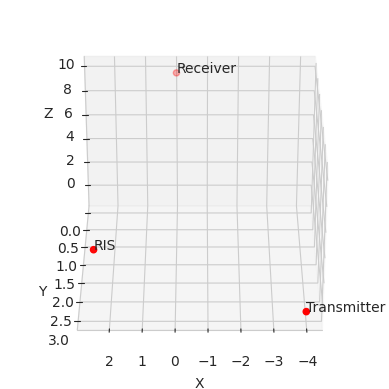

In [122]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x_ =  scene.transmitters["tx"].position 
y_ =  scene.receivers["rx"].position 
z_ = ris.position

ax.scatter(x_, y_, z_, c='r', marker='o')

labels = ['Transmitter ', 'Receiver', 'RIS']
for i, label in enumerate(labels):
    ax.text(x_[i], y_[i], z_[i], label)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=30, azim=90)

# Show the plot
plt.show()

In [123]:
subcarrier_spacing = 312.5e3
fft_size = 128
noise_floor = np.exp(0.1*(-174 + 10*np.log10(subcarrier_spacing) - 30 + 5))
                     
# Compute frequencies of subcarriers and center around carrier frequency
frequencies = scene.frequency + subcarrier_frequencies(fft_size, subcarrier_spacing)
num_repetitions = 1
h_freq_list_no_env = [[None for _ in range(num_repetitions)] for _ in range(len(Rx_locations))]
h_freq_list_with_env = [[None for _ in range(num_repetitions)] for _ in range(len(Rx_locations))]
h_freq_list_with_ris = [[None for _ in range(num_repetitions)] for _ in range(len(Rx_locations))]

for ind in range(len(Rx_locations)):
    print(f'Location:{ind}')
    for rep in range(num_repetitions): 
        #print(f'Rep:{rep}')
        scene.receivers["rx"].position = Rx_locations[ind]
        tf.random.set_seed(1)
        paths = scene.compute_paths(max_depth=1,
                                num_samples=10e6, reflection=True,scattering=True)  # Number of rays shot into directions defined
                                                # by a Fibonacci sphere, too few rays can
                                                # lead to missing paths
        tf.random.set_seed(1)
        a, tau = paths.cir(reflection=False,scattering=False)
                
        h_freq = cir_to_ofdm_channel(frequencies,
                                a,
                                tau,
                                normalize=False) # Non-normalized includes path-loss
        
        h_freq_list_no_env[ind][rep] = h_freq
        tf.random.set_seed(1)
        a, tau = paths.cir(reflection=True,scattering=True)
                
        h_freq = cir_to_ofdm_channel(frequencies,
                                a,
                                tau,
                                normalize=False) # Non-normalized includes path-loss
        
        h_freq_list_with_env[ind][rep] = h_freq
        
        h_freq_list_with_ris[ind][rep],_,_ = ris.ris_channel(scene,frequencies,tx_to_ris_env=True,rx_to_ris_env=True,phase_optimizer=True)

Location:0


Location:1
Location:2
Location:3
Location:4
Location:5
Location:6
Location:7


In [124]:
capacity_vector_no_env = np.zeros([len(Rx_locations)])
capacity_vector_with_env = np.zeros([len(Rx_locations)])
capacity_vector_with_ris = np.zeros([len(Rx_locations)])

for ind in range(len(Rx_locations)):
    for rep in range(num_repetitions):
        
        h_freq = h_freq_list_no_env[ind][rep]
        capacity_vector_no_env[ind] += channel_capacity(subcarrier_spacing, h_freq,noise_floor).numpy().squeeze()  

        h_freq = h_freq_list_with_env[ind][rep]
        capacity_vector_with_env[ind] += channel_capacity(subcarrier_spacing, h_freq,noise_floor).numpy().squeeze()  

        h_freq = h_freq_list_with_env[ind][rep] + h_freq_list_with_ris[ind][rep]
        capacity_vector_with_ris[ind] += channel_capacity(subcarrier_spacing, h_freq,noise_floor).numpy().squeeze()     

capacity_vector_no_env = capacity_vector_no_env/num_repetitions
capacity_vector_with_env = capacity_vector_with_env/num_repetitions
capacity_vector_with_ris = capacity_vector_with_ris/num_repetitions

In [125]:
eigenevalue_vector_no_env = np.zeros([len(Rx_locations),num_repetitions,fft_size,2])
eigenevalue_vector_with_env = np.zeros([len(Rx_locations),num_repetitions,fft_size,2])
eigenevalue_vector_with_ris = np.zeros([len(Rx_locations),num_repetitions,fft_size,2])
for ind in range(len(Rx_locations)):
    for rep in range(num_repetitions):

        ofdm_channel = h_freq_list_no_env[ind][rep]
        ofdm_channel = tf.transpose(ofdm_channel,perm=(0,1,3,5,6,2,4))
        s,_,_ = tf.linalg.svd(ofdm_channel)
        eigenevalue_vector_no_env[ind][rep] = s.numpy().squeeze()  

        ofdm_channel = h_freq_list_with_env[ind][rep]
        ofdm_channel = tf.transpose(ofdm_channel,perm=(0,1,3,5,6,2,4))        
        s,_,_ = tf.linalg.svd(ofdm_channel)
        eigenevalue_vector_with_env[ind][rep] = s.numpy().squeeze()  

        ofdm_channel = h_freq_list_with_env[ind][rep] + h_freq_list_with_ris[ind][rep]
        ofdm_channel = tf.transpose(ofdm_channel,perm=(0,1,3,5,6,2,4))        
        s,_,_ = tf.linalg.svd(ofdm_channel)
        eigenevalue_vector_with_ris[ind][rep] = s.numpy().squeeze()  

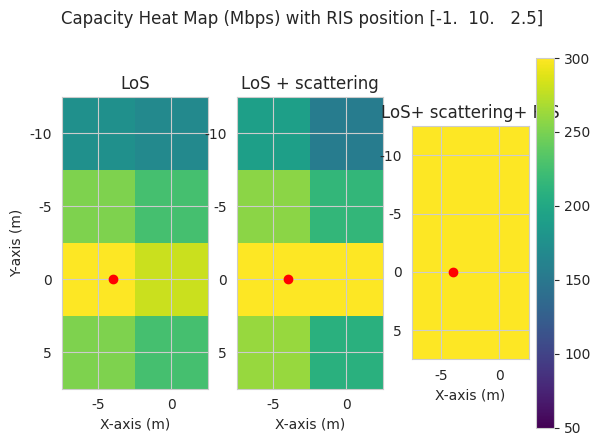

In [126]:
#Plot the capacity 
plt.figure();

# Create a 2D color bar plot
plt.subplot(1,3,1)
plt.imshow(1e-6*capacity_vector_no_env.reshape(y.shape[0],x.shape[0]), cmap='viridis')  # 'viridis' is just an example colormap, you can choose any colormap you like

plt.plot(Tx_location[0]/cell_size + x.size/2,Tx_location[1]/cell_size + y.size/2,'ro')
plt.xlabel('X-axis (m)')
plt.ylabel('Y-axis (m)')
plt.title('LoS')
plt.xticks(range(x.size),x)
plt.yticks(range(y.size),y)
plt.clim(50,300)

plt.subplot(1,3,2)
plt.imshow(1e-6*capacity_vector_with_env.reshape(y.shape[0],x.shape[0]), cmap='viridis')  # 'viridis' is just an example colormap, you can choose any colormap you like

plt.plot(Tx_location[0]/cell_size + x.size/2,Tx_location[1]/cell_size + y.size/2,'ro')
plt.xlabel('X-axis (m)')
plt.title('LoS + scattering')
plt.xticks(range(x.size),x)
plt.yticks(range(y.size),y)
plt.clim(50,300)

plt.subplot(1,3,3)
plt.imshow(1e-6*capacity_vector_with_ris.reshape(y.shape[0],x.shape[0]), cmap='viridis')  # 'viridis' is just an example colormap, you can choose any colormap you like
plt.colorbar()  # Add a color bar

plt.plot(Tx_location[0]/cell_size + x.size/2,Tx_location[1]/cell_size + y.size/2,'ro')
plt.xlabel('X-axis (m)')
plt.title('LoS+ scattering+ RIS')
plt.xticks(range(x.size),x)
plt.yticks(range(y.size),y)
plt.clim(50,300)

plt.suptitle(f'Capacity Heat Map (Mbps) with RIS position {ris.position}')
plt.show()

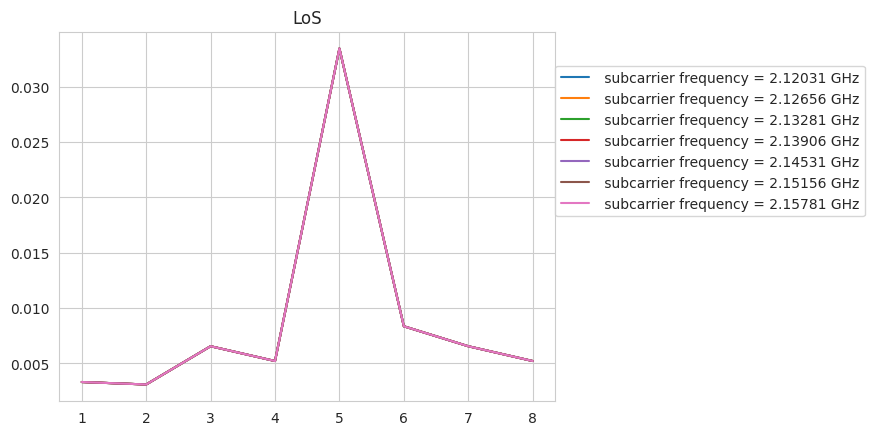

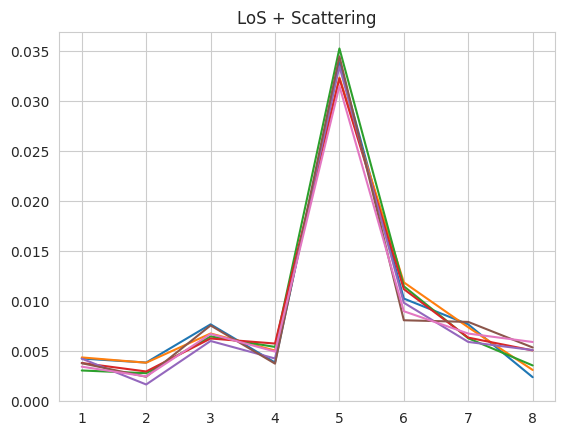

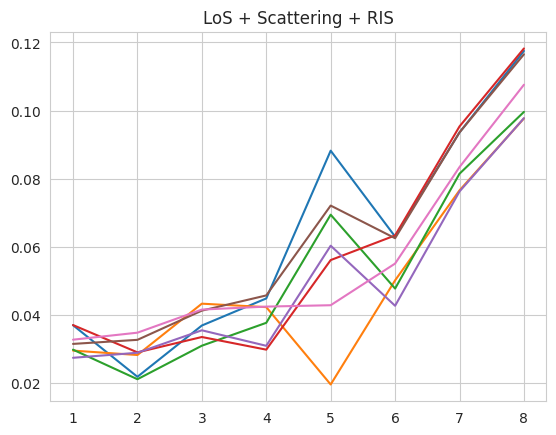

In [127]:
freq = np.arange(1,fft_size,20)
# ============================================
plt.figure();

for index, f in enumerate(freq):
    x = eigenevalue_vector_no_env[:,:,f,0]
    # x = x[x != 0] 
    plt.plot(np.arange(1,len(Rx_locations)+1), x,label=f" subcarrier frequency = {(frequencies[f]/1e9):0,.5f} GHz")
plt.legend(loc=(1, 0.5))
plt.title("LoS")
plt.show()
plt.figure();
# ============================================
for index, f in enumerate(freq):
    x = eigenevalue_vector_with_env[:,:,f,0]
    # x = x[x != 0] 
    plt.plot(np.arange(1,len(Rx_locations)+1), x,label=f" subcarrier frequency = {(frequencies[f]/1e9):0,.5f} GHz")
# plt.legend(loc=(1, 0.5))
plt.title("LoS + Scattering")
plt.show()
# ============================================
plt.figure();

for index, f in enumerate(freq):
    x = eigenevalue_vector_with_ris[:,:,f,0]
    # x = x[x != 0] 
    plt.plot(np.arange(1,len(Rx_locations)+1), x,label=f" subcarrier frequency = {(frequencies[f]/1e9):0,.5f} GHz")
# plt.legend(loc=(1, 0.5))
plt.title("LoS + Scattering + RIS")
plt.show()
